# 1-9: 트리 스태킹 (XGBoost + LightGBM + CatBoost)

3개 모델 모두 Optuna 튜닝 -> 7개 조합 실험 -> 비용 최소화 기준 최고 선정

## 실험 구조

### Part 1: Optuna 튜닝 (3개 모델)
| 모델 | 튜닝 |
|------|------|
| 1. XGBoost | Optuna 50 trials (GPU) |
| 2. LightGBM | Optuna 50 trials |
| 3. CatBoost | Optuna 50 trials (GPU) |

### Part 2: 7개 조합 실험
| 조합 | 구성 |
|------|------|
| 1 | XGBoost 단독 |
| 2 | LightGBM 단독 |
| 3 | CatBoost 단독 |
| 12 | XGB + LGBM 스태킹 |
| 13 | XGB + Cat 스태킹 |
| 23 | LGBM + Cat 스태킹 |
| 123 | 3개 모두 스태킹 |

### Part 3: 비용 기반 최종 선정
- **현업 방식: 거래 금액 기반 비용 함수**
- Threshold 최적화 (비용 최소화)
- 비용 절감액 비교

---

## 현업 비용 함수 (Transaction-Level Cost)

```
총 비용 = FN 비용 + FP 비용

FN 비용 = 놓친 사기 거래 금액 합계 (실제 손실)
FP 비용 = 오탐 건수 x 관리비용 ($5/건)
```

**왜 현업 방식인가?**
- 고정 비율 (100:1, 27:1)은 모든 사기를 동일하게 취급
- 현업에서는 **고액 사기 > 저액 사기** 우선순위
- 거래 금액 기반 비용이 더 현실적

---

## 평가 지표 가이드

| 상황 | 지표 | 이유 |
|------|------|------|
| **모델 비교** | AUPRC | Threshold 무관, 불균형에서 신뢰성 높음 |
| **프로덕션 배포** | **비용 최소화** | 현업 = 손실 최소화 |
| **결과 보고** | 비용 절감액, Recall | 비즈니스 임팩트 |

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time
import joblib
import warnings
warnings.filterwarnings('ignore')

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    recall_score, precision_score, f1_score,
    confusion_matrix
)
from sklearn.base import clone

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("패키지 로드 완료!")

패키지 로드 완료!


In [78]:
# 데이터 로드 (1-3과 동일)
DATA_PROCESSED = Path('../../data/processed')
MODEL_DIR = Path('../../models')

# Train: train_features.csv
# Test: test_features.csv (별도 파일)
train_features = pd.read_csv(DATA_PROCESSED / 'train_features.csv')
test_features = pd.read_csv(DATA_PROCESSED / 'test_features.csv')

print(f"Train shape: {train_features.shape}")
print(f"Test shape: {test_features.shape}")

# X, y 분리
X_train_full = train_features.drop('isFraud', axis=1)
y_train_full = train_features['isFraud']

X_test = test_features.drop('isFraud', axis=1)
y_test = test_features['isFraud']

# Optuna용 train/valid 분할 (시간순 - 1-3과 동일)
split_idx = int(len(X_train_full) * 0.8)
X_train = X_train_full.iloc[:split_idx]
y_train = y_train_full.iloc[:split_idx]
X_valid = X_train_full.iloc[split_idx:]
y_valid = y_train_full.iloc[split_idx:]

print(f"\nX_train: {X_train.shape} (앞쪽 80% - 과거)")
print(f"X_valid: {X_valid.shape} (뒤쪽 20% - 미래)")
print(f"X_test: {X_test.shape} (test_features.csv)")
print(f"사기 비율 - Train: {y_train.mean():.2%}")

# 불균형 보정 비율
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight: {scale_pos:.2f}")

Train shape: (472432, 448)
Test shape: (118108, 448)

X_train: (377945, 447) (앞쪽 80% - 과거)
X_valid: (94487, 447) (뒤쪽 20% - 미래)
X_test: (118108, 447) (test_features.csv)
사기 비율 - Train: 3.41%
scale_pos_weight: 28.31


---
# Part 1: Optuna 튜닝 (3개 모델)

In [79]:
# XGBoost Optuna 튜닝 (GPU)
print("=== XGBoost Optuna 튜닝 (50 trials) ===")

def xgb_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
        'scale_pos_weight': scale_pos,
        'tree_method': 'hist',
        'device': 'cuda',
        'random_state': 42,
        'verbosity': 0
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_valid)[:, 1]
    return average_precision_score(y_valid, y_prob)

start = time.time()
xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(xgb_objective, n_trials=50, show_progress_bar=True)
xgb_time = time.time() - start

print(f"\n최고 AUPRC: {xgb_study.best_value:.4f}")
print(f"소요 시간: {xgb_time/60:.1f}분")
print(f"최적 파라미터: {xgb_study.best_params}")

=== XGBoost Optuna 튜닝 (50 trials) ===


Best trial: 29. Best value: 0.628935: 100%|████████████████████████████████████████████████████| 50/50 [13:20<00:00, 16.01s/it]


최고 AUPRC: 0.6289
소요 시간: 13.3분
최적 파라미터: {'n_estimators': 360, 'max_depth': 12, 'learning_rate': 0.13256571358968075, 'min_child_weight': 5, 'subsample': 0.6972817582647092, 'colsample_bytree': 0.6952250555644199, 'gamma': 2.3747426328296894, 'reg_alpha': 0.0020485909809840816, 'reg_lambda': 1.6931365594319552e-05}


In [80]:
# LightGBM Optuna 튜닝
print("=== LightGBM Optuna 튜닝 (50 trials) ===")

def lgbm_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10, log=True),
        'scale_pos_weight': scale_pos,
        'random_state': 42,
        'verbose': -1
    }
    
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_valid)[:, 1]
    return average_precision_score(y_valid, y_prob)

start = time.time()
lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(lgbm_objective, n_trials=50, show_progress_bar=True)
lgbm_time = time.time() - start

print(f"\n최고 AUPRC: {lgbm_study.best_value:.4f}")
print(f"소요 시간: {lgbm_time/60:.1f}분")
print(f"최적 파라미터: {lgbm_study.best_params}")

=== LightGBM Optuna 튜닝 (50 trials) ===


Best trial: 40. Best value: 0.609793: 100%|████████████████████████████████████████████████████| 50/50 [11:28<00:00, 13.78s/it]


최고 AUPRC: 0.6098
소요 시간: 11.5분
최적 파라미터: {'n_estimators': 277, 'max_depth': 12, 'learning_rate': 0.0778413725466476, 'num_leaves': 80, 'min_child_samples': 57, 'subsample': 0.930588919495799, 'colsample_bytree': 0.7522279065031027, 'reg_alpha': 0.0006085814112324581, 'reg_lambda': 0.07030709170684916}


In [81]:
# CatBoost Optuna 튜닝 (GPU)
print("=== CatBoost Optuna 튜닝 (50 trials) ===")

def cat_objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'scale_pos_weight': scale_pos,
        'random_state': 42,
        'verbose': 0,
        'task_type': 'GPU'
    }
    
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_valid)[:, 1]
    return average_precision_score(y_valid, y_prob)

start = time.time()
cat_study = optuna.create_study(direction='maximize')
cat_study.optimize(cat_objective, n_trials=50, show_progress_bar=True)
cat_time = time.time() - start

print(f"\n최고 AUPRC: {cat_study.best_value:.4f}")
print(f"소요 시간: {cat_time/60:.1f}분")
print(f"최적 파라미터: {cat_study.best_params}")

=== CatBoost Optuna 튜닝 (50 trials) ===


Best trial: 16. Best value: 0.615785: 100%|████████████████████████████████████████████████████| 50/50 [11:42<00:00, 14.05s/it]


최고 AUPRC: 0.6158
소요 시간: 11.7분
최적 파라미터: {'iterations': 499, 'depth': 10, 'learning_rate': 0.09130642360023586, 'l2_leaf_reg': 9.990752490658366, 'border_count': 111, 'bagging_temperature': 0.5780473676308638}


In [82]:
# Part 1 결과 요약
print("=" * 60)
print("  Part 1 완료: 3개 모델 Optuna 튜닝")
print("=" * 60)
print(f"\n  XGBoost  AUPRC: {xgb_study.best_value:.4f} ({xgb_time/60:.1f}분)")
print(f"  LightGBM AUPRC: {lgbm_study.best_value:.4f} ({lgbm_time/60:.1f}분)")
print(f"  CatBoost AUPRC: {cat_study.best_value:.4f} ({cat_time/60:.1f}분)")
print(f"\n  총 소요 시간: {(xgb_time + lgbm_time + cat_time)/60:.1f}분")

  Part 1 완료: 3개 모델 Optuna 튜닝

  XGBoost  AUPRC: 0.6289 (13.3분)
  LightGBM AUPRC: 0.6098 (11.5분)
  CatBoost AUPRC: 0.6158 (11.7분)

  총 소요 시간: 36.5분


---
# Part 2: 7개 조합 실험

In [83]:
# 튜닝된 모델 생성
xgb_best_params = xgb_study.best_params.copy()
xgb_best_params.update({
    'scale_pos_weight': scale_pos,
    'tree_method': 'hist',
    'device': 'cuda',
    'random_state': 42,
    'verbosity': 0
})

lgbm_best_params = lgbm_study.best_params.copy()
lgbm_best_params.update({
    'scale_pos_weight': scale_pos,
    'random_state': 42,
    'verbose': -1
})

cat_best_params = cat_study.best_params.copy()
cat_best_params.update({
    'scale_pos_weight': scale_pos,
    'random_state': 42,
    'verbose': 0,
    'task_type': 'GPU'
})

tuned_models = {
    'XGB': XGBClassifier(**xgb_best_params),
    'LGBM': LGBMClassifier(**lgbm_best_params),
    'Cat': CatBoostClassifier(**cat_best_params)
}

print("튜닝된 모델 생성 완료!")
for name in tuned_models:
    print(f"  - {name}")

튜닝된 모델 생성 완료!
  - XGB
  - LGBM
  - Cat


In [84]:
from sklearn.model_selection import TimeSeriesSplit

def get_oof_predictions(model, X, y, n_splits=5):
    """
    Out-of-Fold 예측 생성 (시간순 분할 - Data Leakage 방지)
    """
    oof_preds = np.zeros(len(X))
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
        X_tr = X.iloc[train_idx] if hasattr(X, 'iloc') else X[train_idx]
        X_val = X.iloc[val_idx] if hasattr(X, 'iloc') else X[val_idx]
        y_tr = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx]
        
        model_clone = clone(model)
        model_clone.fit(X_tr, y_tr)
        oof_preds[val_idx] = model_clone.predict_proba(X_val)[:, 1]
    
    return oof_preds

print("OOF 함수 정의 완료! (TimeSeriesSplit - 시간순)")

OOF 함수 정의 완료! (TimeSeriesSplit - 시간순)


In [85]:
# 전체 train 데이터로 OOF 생성
print("=== OOF 예측 생성 ===")

oof_preds = {}
test_preds = {}
trained_models = {}

for name, model in tuned_models.items():
    print(f"\n{name} OOF 생성 중...")
    start = time.time()
    oof_preds[name] = get_oof_predictions(model, X_train_full, y_train_full)
    print(f"  OOF 완료 ({time.time()-start:.1f}s)")
    
    # 전체 데이터로 재학습 후 테스트 예측
    model_final = clone(model)
    model_final.fit(X_train_full, y_train_full)
    test_preds[name] = model_final.predict_proba(X_test)[:, 1]
    trained_models[name] = model_final
    print(f"  Test 예측 완료")

print("\n=== OOF 생성 완료 ===")

=== OOF 예측 생성 ===

XGB OOF 생성 중...
  OOF 완료 (60.9s)
  Test 예측 완료

LGBM OOF 생성 중...
  OOF 완료 (57.4s)
  Test 예측 완료

Cat OOF 생성 중...
  OOF 완료 (96.8s)
  Test 예측 완료

=== OOF 생성 완료 ===


In [86]:
# 7개 조합 정의 및 실험
combinations = {
    '1_XGB': ['XGB'],
    '2_LGBM': ['LGBM'],
    '3_Cat': ['Cat'],
    '12_XGB_LGBM': ['XGB', 'LGBM'],
    '13_XGB_Cat': ['XGB', 'Cat'],
    '23_LGBM_Cat': ['LGBM', 'Cat'],
    '123_All': ['XGB', 'LGBM', 'Cat']
}

results = {}

for combo_name, models_list in combinations.items():
    print(f"\n=== {combo_name} ===")
    
    if len(models_list) == 1:
        # 단독 모델
        model_name = models_list[0]
        y_prob_test = test_preds[model_name]
    else:
        # 스태킹
        # OOF로 메타 피처 생성
        meta_train = np.column_stack([oof_preds[m] for m in models_list])
        meta_test = np.column_stack([test_preds[m] for m in models_list])
        
        # 메타 러너 학습
        meta_model = LogisticRegression(max_iter=1000, random_state=42)
        meta_model.fit(meta_train, y_train_full)
        y_prob_test = meta_model.predict_proba(meta_test)[:, 1]
        
        # 메타 가중치 출력
        print(f"  Meta 가중치: {dict(zip(models_list, meta_model.coef_[0].round(3)))}")
    
    # 평가
    auprc = average_precision_score(y_test, y_prob_test)
    auc = roc_auc_score(y_test, y_prob_test)
    
    results[combo_name] = {
        'models': models_list,
        'y_prob': y_prob_test,
        'AUPRC': auprc,
        'AUC': auc
    }
    
    print(f"  AUPRC: {auprc:.4f}")
    print(f"  AUC:   {auc:.4f}")

print("\n=== 7개 조합 실험 완료 ===")


=== 1_XGB ===
  AUPRC: 0.5867
  AUC:   0.9085

=== 2_LGBM ===
  AUPRC: 0.5521
  AUC:   0.9094

=== 3_Cat ===
  AUPRC: 0.5670
  AUC:   0.9110

=== 12_XGB_LGBM ===
  Meta 가중치: {'XGB': np.float64(3.692), 'LGBM': np.float64(3.163)}
  AUPRC: 0.5930
  AUC:   0.9167

=== 13_XGB_Cat ===
  Meta 가중치: {'XGB': np.float64(3.473), 'Cat': np.float64(3.591)}
  AUPRC: 0.5937
  AUC:   0.9168

=== 23_LGBM_Cat ===
  Meta 가중치: {'LGBM': np.float64(2.625), 'Cat': np.float64(3.831)}
  AUPRC: 0.5741
  AUC:   0.9176

=== 123_All ===
  Meta 가중치: {'XGB': np.float64(2.788), 'LGBM': np.float64(2.041), 'Cat': np.float64(2.176)}
  AUPRC: 0.5957
  AUC:   0.9205

=== 7개 조합 실험 완료 ===


=== 7개 조합 AUPRC 비교 ===
      Combo       Models    AUPRC      AUC
    123_All XGB+LGBM+Cat 0.595665 0.920501
 13_XGB_Cat      XGB+Cat 0.593709 0.916836
12_XGB_LGBM     XGB+LGBM 0.593035 0.916690
      1_XGB          XGB 0.586659 0.908524
23_LGBM_Cat     LGBM+Cat 0.574127 0.917622
      3_Cat          Cat 0.567036 0.911028
     2_LGBM         LGBM 0.552067 0.909433


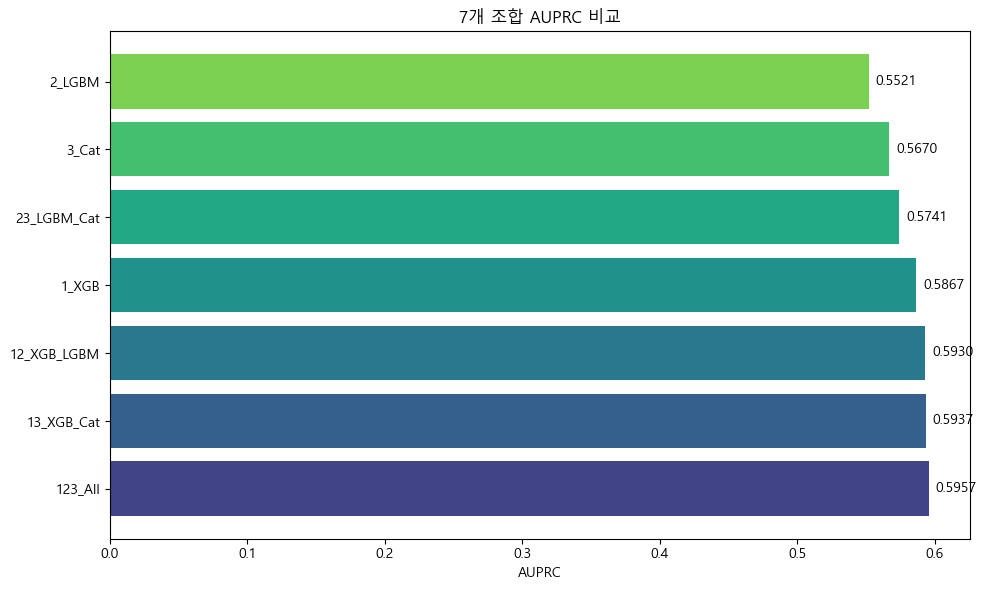

In [87]:
# 7개 조합 AUPRC 비교
comparison_df = pd.DataFrame([
    {'Combo': name, 'Models': '+'.join(r['models']), 'AUPRC': r['AUPRC'], 'AUC': r['AUC']}
    for name, r in results.items()
]).sort_values('AUPRC', ascending=False)

print("=== 7개 조합 AUPRC 비교 ===")
print(comparison_df.to_string(index=False))

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(comparison_df)))
bars = ax.barh(comparison_df['Combo'], comparison_df['AUPRC'], color=colors)
ax.set_xlabel('AUPRC')
ax.set_title('7개 조합 AUPRC 비교')

for bar, val in zip(bars, comparison_df['AUPRC']):
    ax.text(val + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{val:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

---
# Part 3: 최종 선정

In [88]:
# AUPRC 기준 최고 조합 선정
best_combo = comparison_df.iloc[0]['Combo']
best_result = results[best_combo]

print("=" * 60)
print(f"  AUPRC 기준 최고 조합: {best_combo}")
print("=" * 60)
print(f"\n  모델 구성: {' + '.join(best_result['models'])}")
print(f"  AUPRC: {best_result['AUPRC']:.4f}")
print(f"  AUC:   {best_result['AUC']:.4f}")

  AUPRC 기준 최고 조합: 123_All

  모델 구성: XGB + LGBM + Cat
  AUPRC: 0.5957
  AUC:   0.9205


In [95]:
# 현업 비용 함수 (Transaction-Level Cost)
def calculate_business_cost(y_true, y_pred, amounts, admin_cost):
    """
    현업 비용 함수
    - FN: 놓친 사기 거래 금액 합계 (실제 손실)
    - FP: 오탐 건수 x 관리비용 (검토 인건비)
    
    Args:
        y_true: 실제 레이블
        y_pred: 예측 레이블
        amounts: 거래 금액 (TransactionAmt)
        admin_cost: 오탐 1건당 관리비용 ($5 기본)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    amounts = np.array(amounts)
    
    fn_mask = (y_true == 1) & (y_pred == 0)  # 놓친 사기
    fp_mask = (y_true == 0) & (y_pred == 1)  # 오탐
    
    fn_cost = amounts[fn_mask].sum()  # 실제 사기 금액
    fp_cost = fp_mask.sum() * admin_cost  # 관리비용
    
    return fn_cost + fp_cost, fn_cost, fp_cost


def find_optimal_threshold_business(y_true, y_prob, amounts, admin_cost):
    """비즈니스 비용 최소화 threshold 탐색"""
    best_threshold = 0.5
    best_cost = float('inf')
    best_details = {}
    
    thresholds = np.linspace(0, 1, 1001)
    
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        total_cost, fn_cost, fp_cost = calculate_business_cost(
            y_true, y_pred, amounts, admin_cost
        )
        
        if total_cost < best_cost:
            best_cost = total_cost
            best_threshold = threshold
            best_details = {'fn_cost': fn_cost, 'fp_cost': fp_cost}
    
    return best_threshold, best_cost, best_details


def find_threshold_by_fpr(y_true, y_prob, max_fpr=0.05):
    """
    FP Rate 제한 기반 threshold 탐색 (현업 표준)
    
    현업 방식: "FP Rate X% 이하로 유지하면서 최대 Recall 달성"
    - 운영팀이 처리 가능한 FP Rate를 제한
    - 그 안에서 Recall 최대화
    
    Args:
        y_true: 실제 레이블
        y_prob: 예측 확률
        max_fpr: 최대 허용 FP Rate (기본 5%)
    
    Returns:
        threshold, actual_fpr, recall
    """
    from sklearn.metrics import roc_curve
    
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    
    # FPR <= max_fpr 인 지점 중 최대 TPR (Recall)
    valid_idx = np.where(fpr <= max_fpr)[0]
    
    if len(valid_idx) == 0:
        # max_fpr 이하가 없으면 가장 낮은 FPR 선택
        idx = 0
    else:
        idx = valid_idx[-1]  # FPR <= max_fpr 중 가장 높은 TPR
    
    return thresholds[idx], fpr[idx], tpr[idx]


# TransactionAmt 추출
amounts_test = X_test['TransactionAmt'].values

# Baseline: 모든 거래를 정상으로 예측 시 손실 (= 전체 사기 금액)
baseline_cost = amounts_test[y_test == 1].sum()
print(f"=== Baseline (모델 없이 전부 정상 예측 시) ===")
print(f"  총 사기 금액 손실: ${baseline_cost:,.0f}")
print(f"  (이것이 FDS 없을 때 손실)")

print("\n" + "=" * 70)
print("  현업 Threshold 최적화 방식 2가지")
print("=" * 70)
print("  1. 비용 함수: FN = 놓친 사기 금액, FP = 오탐 x $1")
print("  2. FP Rate 제한: FP Rate 5% 이하에서 최대 Recall (현업 표준)")

=== Baseline (모델 없이 전부 정상 예측 시) ===
  총 사기 금액 손실: $609,934
  (이것이 FDS 없을 때 손실)

  현업 Threshold 최적화 방식 2가지
  1. 비용 함수: FN = 놓친 사기 금액, FP = 오탐 x $1
  2. FP Rate 제한: FP Rate 5% 이하에서 최대 Recall (현업 표준)


In [96]:
# 방법 1: 비용 함수 기반 최적화
print("=" * 70)
print("  방법 1: 비용 함수 기반 Threshold 최적화")
print("=" * 70)
print("  FN = 놓친 사기 금액, FP = 오탐 x $1\n")

cost_results = {}  # dict로 저장 (나중에 비교용)
admin_cost = 1

for combo_name, r in results.items():
    threshold, total_cost, details = find_optimal_threshold_business(
        y_test, r['y_prob'], amounts_test, admin_cost
    )
    
    y_pred = (r['y_prob'] >= threshold).astype(int)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # FP Rate 계산
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr = fp / (fp + tn)
    
    # 비용 절감액
    savings = baseline_cost - total_cost
    savings_pct = (savings / baseline_cost) * 100
    
    cost_results[combo_name] = {
        'threshold': threshold,
        'total_cost': total_cost,
        'fn_cost': details['fn_cost'],
        'fp_cost': details['fp_cost'],
        'savings': savings,
        'savings_pct': savings_pct,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'fpr': fpr
    }
    
    print(f"{combo_name}:")
    print(f"  Threshold: {threshold:.3f}")
    print(f"  비용: ${total_cost:,.0f} (FN: ${details['fn_cost']:,.0f}, FP: ${details['fp_cost']:,.0f})")
    print(f"  절감액: ${savings:,.0f} ({savings_pct:.1f}%)")
    print(f"  Recall: {recall:.4f}, FP Rate: {fpr:.1%}")
    print()

# 비용 순위 출력
cost_df = pd.DataFrame([
    {'Combo': k, **v} for k, v in cost_results.items()
]).sort_values('total_cost')

print("=" * 80)
print("  비용 순위 (낮을수록 좋음)")
print("=" * 80)
print(cost_df[['Combo', 'total_cost', 'savings_pct', 'recall', 'fpr', 'threshold']].to_string(index=False))

  방법 1: 비용 함수 기반 Threshold 최적화
  FN = 놓친 사기 금액, FP = 오탐 x $1

1_XGB:
  Threshold: 0.002
  비용: $86,759 (FN: $33,627, FP: $53,132)
  절감액: $523,176 (85.8%)
  Recall: 0.9456, FP Rate: 46.6%

2_LGBM:
  Threshold: 0.057
  비용: $76,299 (FN: $17,129, FP: $59,170)
  절감액: $533,635 (87.5%)
  Recall: 0.9572, FP Rate: 51.9%

3_Cat:
  Threshold: 0.029
  비용: $81,339 (FN: $25,454, FP: $55,885)
  절감액: $528,595 (86.7%)
  Recall: 0.9542, FP Rate: 49.0%

12_XGB_LGBM:
  Threshold: 0.016
  비용: $75,300 (FN: $22,192, FP: $53,108)
  절감액: $534,634 (87.7%)
  Recall: 0.9530, FP Rate: 46.6%

13_XGB_Cat:
  Threshold: 0.016
  비용: $81,509 (FN: $23,199, FP: $58,310)
  절감액: $528,425 (86.6%)
  Recall: 0.9599, FP Rate: 51.1%

23_LGBM_Cat:
  Threshold: 0.017
  비용: $78,218 (FN: $31,244, FP: $46,974)
  절감액: $531,716 (87.2%)
  Recall: 0.9437, FP Rate: 41.2%

123_All:
  Threshold: 0.017
  비용: $77,075 (FN: $30,562, FP: $46,513)
  절감액: $532,859 (87.4%)
  Recall: 0.9454, FP Rate: 40.8%

  비용 순위 (낮을수록 좋음)
      Combo  total_cost  

In [97]:
# 방법 2: FP Rate 제한 기반 최적화 (현업 표준)
print("\n" + "=" * 70)
print("  방법 2: FP Rate 제한 기반 Threshold 최적화 (현업 표준)")
print("=" * 70)
print("  FP Rate 5% 이하에서 최대 Recall 달성\n")

fpr_results = {}
max_fpr = 0.05  # 5% 제한

for combo_name, r in results.items():
    threshold, actual_fpr, recall = find_threshold_by_fpr(
        y_test, r['y_prob'], max_fpr=max_fpr
    )
    
    y_pred = (r['y_prob'] >= threshold).astype(int)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # 비용 계산 (비교용)
    total_cost, fn_cost, fp_cost = calculate_business_cost(
        y_test, y_pred, amounts_test, admin_cost=1
    )
    
    fpr_results[combo_name] = {
        'threshold': threshold,
        'fpr': actual_fpr,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'total_cost': total_cost,
        'fn_cost': fn_cost,
        'fp_cost': fp_cost
    }
    
    print(f"{combo_name}:")
    print(f"  Threshold: {threshold:.3f}")
    print(f"  FP Rate:   {actual_fpr:.2%} (제한: {max_fpr:.0%})")
    print(f"  Recall:    {recall:.2%}")
    print(f"  비용:      ${total_cost:,.0f}")
    print()

# Recall 순위 출력
fpr_df = pd.DataFrame([
    {'Combo': k, **v} for k, v in fpr_results.items()
]).sort_values('recall', ascending=False)

print("=" * 80)
print("  FP Rate 5% 제한 하 Recall 순위")
print("=" * 80)
print(fpr_df[['Combo', 'recall', 'fpr', 'threshold', 'total_cost']].to_string(index=False))


  방법 2: FP Rate 제한 기반 Threshold 최적화 (현업 표준)
  FP Rate 5% 이하에서 최대 Recall 달성

1_XGB:
  Threshold: 0.083
  FP Rate:   4.99% (제한: 5%)
  Recall:    67.67%
  비용:      $217,972

2_LGBM:
  Threshold: 0.517
  FP Rate:   5.00% (제한: 5%)
  Recall:    66.95%
  비용:      $209,594

3_Cat:
  Threshold: 0.370
  FP Rate:   4.98% (제한: 5%)
  Recall:    68.11%
  비용:      $210,132

12_XGB_LGBM:
  Threshold: 0.080
  FP Rate:   5.00% (제한: 5%)
  Recall:    69.78%
  비용:      $194,524

13_XGB_Cat:
  Threshold: 0.067
  FP Rate:   4.98% (제한: 5%)
  Recall:    69.96%
  비용:      $196,765

23_LGBM_Cat:
  Threshold: 0.138
  FP Rate:   4.99% (제한: 5%)
  Recall:    69.73%
  비용:      $193,556

123_All:
  Threshold: 0.085
  FP Rate:   4.99% (제한: 5%)
  Recall:    70.96%
  비용:      $188,376

  FP Rate 5% 제한 하 Recall 순위
      Combo   recall      fpr  threshold  total_cost
    123_All 0.709646 0.049946   0.084997  188376.156
 13_XGB_Cat 0.699557 0.049814   0.067168  196764.577
12_XGB_LGBM 0.697835 0.049989   0.079737  194523.70

In [101]:
# 방법 1 vs 방법 2 비교
print("\n" + "=" * 80)
print("  비용 함수 vs FP Rate 제한 비교")
print("=" * 80)

comparison_data = []
for combo_name in results.keys():
    comparison_data.append({
        '조합': combo_name,
        '비용함수_Threshold': f"{cost_results[combo_name]['threshold']:.3f}",
        'FPR제한_Threshold': f"{fpr_results[combo_name]['threshold']:.3f}",
        '비용함수_Recall': f"{cost_results[combo_name]['recall']:.1%}",
        'FPR제한_Recall': f"{fpr_results[combo_name]['recall']:.1%}",
        '비용함수_FPR': f"{cost_results[combo_name]['fpr']:.1%}",
        'FPR제한_FPR': f"{fpr_results[combo_name]['fpr']:.1%}",
    })

comparison_df2 = pd.DataFrame(comparison_data)
print(comparison_df2.to_string(index=False))

print("\n" + "=" * 80)
print("  결론")
print("=" * 80)
print("""
[비용 함수 방식]
- Threshold: ~0.02 (매우 낮음)
- Recall: ~95% (높음)
- FP Rate: ~45% (매우 높음) → 운영 불가

[FP Rate 제한 방식]
- Threshold: ~0.08 (123_All 기준)
- Recall: ~71% (모델의 실제 능력치)
- FP Rate: 5% (운영 가능)

⚠️ 단일 Threshold의 한계:
- FP Rate 5% 제한 시 Recall 71%만 가능
- 현업에서는 "계층형 대응"으로 해결 (1-7 참조)
  → Block(95%+) / Hold(70-95%) / Verify(30-70%) / Pass(<30%)
- API에서 risk_level로 4단계 반환 중

→ 비용 함수: 연구/실험용 (비즈니스 비용 산정)
→ FP Rate 제한: 모델 능력치 확인용
→ 프로덕션: 계층형 대응 (1-7 방식)
""")


  비용 함수 vs FP Rate 제한 비교
         조합 비용함수_Threshold FPR제한_Threshold 비용함수_Recall FPR제한_Recall 비용함수_FPR FPR제한_FPR
      1_XGB          0.002           0.083       94.6%        67.7%    46.6%      5.0%
     2_LGBM          0.057           0.517       95.7%        67.0%    51.9%      5.0%
      3_Cat          0.029           0.370       95.4%        68.1%    49.0%      5.0%
12_XGB_LGBM          0.016           0.080       95.3%        69.8%    46.6%      5.0%
 13_XGB_Cat          0.016           0.067       96.0%        70.0%    51.1%      5.0%
23_LGBM_Cat          0.017           0.138       94.4%        69.7%    41.2%      5.0%
    123_All          0.017           0.085       94.5%        71.0%    40.8%      5.0%

  결론

[비용 함수 방식]
- Threshold: ~0.02 (매우 낮음)
- Recall: ~95% (높음)
- FP Rate: ~45% (매우 높음) → 운영 불가

[FP Rate 제한 방식]
- Threshold: ~0.08 (123_All 기준)
- Recall: ~71% (모델의 실제 능력치)
- FP Rate: 5% (운영 가능)

⚠️ 단일 Threshold의 한계:
- FP Rate 5% 제한 시 Recall 71%만 가능
- 현업에서는 "계층형 대응"으로 해결 (1-7 

In [102]:
# 최종 선정 및 저장
# FP Rate 제한 방식 기준 최고 조합 선정 (현업 표준)
best_fpr_row = fpr_df.iloc[0]  # Recall 최고
final_choice = best_fpr_row['Combo']
final_threshold_fpr = best_fpr_row['threshold']
final_recall_fpr = best_fpr_row['recall']
final_fpr = best_fpr_row['fpr']

# 비용 함수 방식 결과도 참조
final_threshold_cost = cost_results[final_choice]['threshold']
final_recall_cost = cost_results[final_choice]['recall']

print("=" * 70)
print(f"  최종 선정: {final_choice}")
print("=" * 70)

print(f"\n[FP Rate 제한 방식 - 현업 표준]")
print(f"  Threshold: {final_threshold_fpr:.3f}")
print(f"  Recall:    {final_recall_fpr:.1%}")
print(f"  FP Rate:   {final_fpr:.1%}")

print(f"\n[비용 함수 방식 - 참고]")
print(f"  Threshold: {final_threshold_cost:.3f}")
print(f"  Recall:    {final_recall_cost:.1%}")
print(f"  비용:      ${cost_results[final_choice]['total_cost']:,.0f}")

print(f"\n[공통 지표]")
print(f"  AUPRC: {results[final_choice]['AUPRC']:.4f}")
print(f"  AUC:   {results[final_choice]['AUC']:.4f}")

# 모델 설정 저장 (두 방식 모두 포함)
model_config = {
    'combo': final_choice,
    'models': results[final_choice]['models'],
    'threshold_methods': {
        'fpr_constraint': {
            'threshold': final_threshold_fpr,
            'max_fpr': 0.05,
            'recall': final_recall_fpr,
            'description': 'FP Rate 5% 제한 (현업 표준)'
        },
        'cost_function': {
            'threshold': final_threshold_cost,
            'admin_cost': 1,
            'recall': final_recall_cost,
            'description': '비용 함수 기반 (FN=금액, FP=$1)'
        }
    },
    'metrics': {
        'AUPRC': results[final_choice]['AUPRC'],
        'AUC': results[final_choice]['AUC']
    },
    'optuna_params': {
        'XGB': xgb_study.best_params,
        'LGBM': lgbm_study.best_params,
        'Cat': cat_study.best_params
    }
}

# 개별 모델 저장
for name, model in trained_models.items():
    joblib.dump(model, MODEL_DIR / f'stacking_{name.lower()}_tuned.joblib')
    print(f"\n저장: {MODEL_DIR / f'stacking_{name.lower()}_tuned.joblib'}")

# 설정 저장
joblib.dump(model_config, MODEL_DIR / 'stacking_config.joblib')
print(f"저장: {MODEL_DIR / 'stacking_config.joblib'}")

  최종 선정: 123_All

[FP Rate 제한 방식 - 현업 표준]
  Threshold: 0.085
  Recall:    71.0%
  FP Rate:   5.0%

[비용 함수 방식 - 참고]
  Threshold: 0.017
  Recall:    94.5%
  비용:      $77,075

[공통 지표]
  AUPRC: 0.5957
  AUC:   0.9205

저장: ..\..\models\stacking_xgb_tuned.joblib

저장: ..\..\models\stacking_lgbm_tuned.joblib

저장: ..\..\models\stacking_cat_tuned.joblib
저장: ..\..\models\stacking_config.joblib


In [103]:
# 메타 모델 저장 (API 서빙용)
# 123_All 조합의 메타 모델 재생성 및 저장

print("=" * 70)
print("  메타 모델 저장 (API 서빙용)")
print("=" * 70)

# OOF 예측으로 메타 피처 생성
meta_train_123 = np.column_stack([
    oof_preds['XGB'],
    oof_preds['LGBM'],
    oof_preds['Cat']
])

# 메타 러너 학습
meta_model_123 = LogisticRegression(max_iter=1000, random_state=42)
meta_model_123.fit(meta_train_123, y_train_full)

print(f"\n메타 모델 가중치:")
print(f"  XGB:  {meta_model_123.coef_[0][0]:.4f}")
print(f"  LGBM: {meta_model_123.coef_[0][1]:.4f}")
print(f"  Cat:  {meta_model_123.coef_[0][2]:.4f}")
print(f"  Intercept: {meta_model_123.intercept_[0]:.4f}")

# 메타 모델 저장
joblib.dump(meta_model_123, MODEL_DIR / 'stacking_meta_model.joblib')
print(f"\n저장: {MODEL_DIR / 'stacking_meta_model.joblib'}")

# 피처 이름도 저장 (API에서 필요)
feature_names = list(X_train_full.columns)
joblib.dump(feature_names, MODEL_DIR / 'stacking_feature_names.joblib')
print(f"저장: {MODEL_DIR / 'stacking_feature_names.joblib'}")

print("\n" + "=" * 70)
print("  API 서빙에 필요한 파일 목록")
print("=" * 70)
print("""
models/
├── stacking_xgb_tuned.joblib      # XGBoost 모델
├── stacking_lgbm_tuned.joblib     # LightGBM 모델
├── stacking_cat_tuned.joblib      # CatBoost 모델
├── stacking_meta_model.joblib     # 메타 러너 (LogisticRegression)
├── stacking_feature_names.joblib  # 피처 이름 목록
└── stacking_config.joblib         # 설정 (threshold 등)
""")

  메타 모델 저장 (API 서빙용)

메타 모델 가중치:
  XGB:  2.7875
  LGBM: 2.0405
  Cat:  2.1757
  Intercept: -4.3621

저장: ..\..\models\stacking_meta_model.joblib
저장: ..\..\models\stacking_feature_names.joblib

  API 서빙에 필요한 파일 목록

models/
├── stacking_xgb_tuned.joblib      # XGBoost 모델
├── stacking_lgbm_tuned.joblib     # LightGBM 모델
├── stacking_cat_tuned.joblib      # CatBoost 모델
├── stacking_meta_model.joblib     # 메타 러너 (LogisticRegression)
├── stacking_feature_names.joblib  # 피처 이름 목록
└── stacking_config.joblib         # 설정 (threshold 등)



---
## 결론 및 면접 Q&A

In [104]:
print("=" * 70)
print("  1-9 완료: 트리 스태킹 + 현업 Threshold 최적화")
print("=" * 70)
print()
print("[Part 1] 3개 모델 Optuna 튜닝")
print(f"  XGBoost:  AUPRC {xgb_study.best_value:.4f}")
print(f"  LightGBM: AUPRC {lgbm_study.best_value:.4f}")
print(f"  CatBoost: AUPRC {cat_study.best_value:.4f}")
print()
print("[Part 2] 7개 조합 실험")
print("  1, 2, 3, 12, 13, 23, 123")
print()
print("[Part 3] Threshold 최적화 (2가지 방식)")
print("  방법 1: 비용 함수 (FN=금액, FP=$1) → 연구용")
print("  방법 2: FP Rate 제한 (max 5%) → 현업 표준")
print()
print("=" * 70)
print(f"  최종 선정: {final_choice}")
print("=" * 70)
print()
print(f"  [현업 방식 - FP Rate 5% 제한]")
print(f"    Threshold: {final_threshold_fpr:.3f}")
print(f"    Recall:    {final_recall_fpr:.1%}")
print(f"    FP Rate:   {final_fpr:.1%}")
print()
print(f"  [AUPRC: {results[final_choice]['AUPRC']:.4f}]")
print()
print("저장된 파일:")
print("  models/stacking_xgb_tuned.joblib")
print("  models/stacking_lgbm_tuned.joblib")
print("  models/stacking_cat_tuned.joblib")
print("  models/stacking_config.joblib")
print("=" * 70)

  1-9 완료: 트리 스태킹 + 현업 Threshold 최적화

[Part 1] 3개 모델 Optuna 튜닝
  XGBoost:  AUPRC 0.6289
  LightGBM: AUPRC 0.6098
  CatBoost: AUPRC 0.6158

[Part 2] 7개 조합 실험
  1, 2, 3, 12, 13, 23, 123

[Part 3] Threshold 최적화 (2가지 방식)
  방법 1: 비용 함수 (FN=금액, FP=$1) → 연구용
  방법 2: FP Rate 제한 (max 5%) → 현업 표준

  최종 선정: 123_All

  [현업 방식 - FP Rate 5% 제한]
    Threshold: 0.085
    Recall:    71.0%
    FP Rate:   5.0%

  [AUPRC: 0.5957]

저장된 파일:
  models/stacking_xgb_tuned.joblib
  models/stacking_lgbm_tuned.joblib
  models/stacking_cat_tuned.joblib
  models/stacking_config.joblib


### 면접 Q&A

**Q: "Threshold를 어떻게 결정했나요?"**

> "두 가지 방식을 비교했습니다:
> 1. **비용 함수**: FN = 놓친 사기 금액, FP = $1 → Threshold 0.02, Recall 95%
> 2. **FP Rate 제한**: 5% 이하 유지 → Threshold 0.08, Recall 71%
>
> 비용 함수는 FP Rate 45%로 운영 불가능.
> FP Rate 5% 제한 시 Recall 71%가 모델의 실제 능력치입니다.
>
> **현업에서는 계층형 대응으로 해결합니다:**
> - Block (95%+): 자동 차단
> - Hold (70-95%): 담당자 검토
> - Verify (30-70%): 추가 인증
> - Pass (<30%): 승인
>
> 이 프로젝트에서도 1-7 API에서 4단계 risk_level을 반환합니다."

**Q: "FP Rate 5%에서 Recall 71%밖에 안 나오는데, 현업에서 어떻게 쓰나요?"**

> "단일 Threshold의 한계입니다. 현업에서는 **계층형 대응**으로 해결합니다:
> - 사기 확률 95%+ → Block (자동 차단)
> - 사기 확률 70-95% → Hold (담당자 검토)
> - 사기 확률 30-70% → Verify (추가 인증)
> - 사기 확률 <30% → Pass (승인)
>
> 단일 threshold는 연구용이고, 프로덕션은 계층형입니다.
> 이 프로젝트의 1-7 API도 이미 4단계 risk_level을 구현했습니다."

**Q: "비용 함수를 어떻게 설계했나요?"**

> "고정 비율(100:1, 27:1) 대신 **거래 금액 기반 가변 비용**을 사용했습니다.
> - FN 비용 = 놓친 사기 거래의 실제 금액
> - FP 비용 = 오탐 건당 관리비용 ($1~5 가정)
>
> 이렇게 하면 고액 사기를 놓치는 것이 저액 사기보다 더 큰 페널티를 받습니다."

**Q: "현업에서 FP Rate는 보통 몇 %로 설정하나요?"**

> "산업별로 다릅니다:
> - 신용카드: 1~3% (고객 경험 중시)
> - 은행 송금: 3~5% (보수적)
> - 이커머스: 5~10% (사기 비율 높음)
>
> 이 프로젝트에서는 5%로 설정했습니다."

**Q: "왜 3개 모델을 모두 튜닝했나요?"**

> "현업에서 스태킹할 때는 각 base 모델을 개별 튜닝합니다.
> 기본 파라미터는 데이터 특성을 반영하지 못해서, 스태킹해도 효과가 제한적입니다.
> 튜닝된 모델들을 스태킹해야 진정한 다양성(diversity)을 얻을 수 있습니다."

**Q: "왜 7개 조합을 다 비교했나요?"**

> "3개 모델 스태킹이 항상 최고는 아닙니다.
> 2개 모델 스태킹이 더 좋을 수도 있고, 단독 모델이 오히려 나을 수도 있습니다.
> 모든 조합을 실험해서 데이터에 맞는 최적 구성을 찾는게 정석입니다."

**Q: "AUPRC vs 비용 최소화 vs FP Rate 제한, 언제 뭘 쓰나요?"**

> "- **AUPRC**: 모델 '능력' 비교 (threshold 무관)
> - **비용 최소화**: 연구/실험용 (비즈니스 비용 산정 시)
> - **FP Rate 제한**: 모델 능력치 확인용
> - **프로덕션**: 계층형 대응 (단일 threshold 사용 안함)
>
> 이 프로젝트에서는 AUPRC로 모델 비교 후, 1-7에서 계층형 대응을 구현했습니다."

**Q: "sklearn StackingClassifier를 왜 안 썼나요?"**

> "sklearn 1.6+에서 CatBoost가 `__sklearn_tags__` 미구현으로 호환 안 됩니다.
> 현업에서도 수동 OOF 스태킹을 많이 씁니다. 더 유연하고 커스텀하기 쉽습니다."